In [1]:
DEBUG = False
N_DEBUG = 100

In [2]:
import pandas as pd
import time
import numpy as np

from detector_radford import DetectorRadford
from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
from detector_dummy import DetectorDummy
from explainer_wrappers import LIME_Explainer, SHAP_Explainer, Anchor_Explainer

results = []


In [3]:
import transformers
from transformers import pipeline

import torch
import re
import sklearn
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
test = pd.read_pickle("./dataset_test.pkl")
# test_machine = test[test["author"] != "human_answers"]

# test = test[test["author"] == "human_answers"]

# print("len(test_human)", len(test))
documents = test["answer"]
# documents_machine = test_machine["answer"]
gold_labels = test["author"] == "human_answers" # convention: 0: machine, 1: human, see detector.py




#from gpt2outputdataset.detector_radford import DetectorRadford
#from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
detector_classes = [DetectorRadford,DetectorGuo]

from explainer_wrappers import LIME_Explainer, SHAP_Explainer
explainer_classes = [SHAP_Explainer,LIME_Explainer]

In [5]:
DEVICE = "cuda"
pattern = re.compile(r"<extra_id_\d+>")

base_model_name="facebook/opt-350m"
openai_model = False

cache_dir="./.cache"
# mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model, cache_dir=cache_dir).to(DEVICE)
# mask_tokenizer = transformers.AutoTokenizer.from_pretrained(model, model_max_length=mask_model.config.n_positions, cache_dir=cache_dir)#.to(DEVICE)
do_top_k= False
do_top_p= False

In [6]:

base_model = transformers.AutoModelForCausalLM.from_pretrained(base_model_name, cache_dir=cache_dir).to(DEVICE)




base_tokenizer = transformers.AutoTokenizer.from_pretrained(base_model_name, cache_dir=cache_dir, padding_side='left',)


In [7]:
predictions = None

In [8]:
decoded = None

In [9]:
import os

In [10]:
from tqdm import tqdm
import itertools


In [11]:
documents

112    I've heard of handyman type people making a li...
24     No. Securities brokers/dealers in the United S...
95     Yes, buying REITs (Real Estate Investment Trus...
689    Institutional investors are organizations that...
600    Hello and Welcome to ‘Ask A Doctor’ service.I ...
                             ...                        
148    I believe that capital gains do affect AGI, bu...
733    There are many potential causes of fever, shiv...
354    I know it may not last longer but i was able t...
909    Online stock brokers typically get their real-...
27     In financial markets, the terms "bid" and "ask...
Name: answer, Length: 305, dtype: object

# Generate/Load documents
Generate or load documents from `./contrastivity_label_flip_pairs.csv`

In [12]:
columns=["Detector", "Original", "Prompt", "Edited", "f(Original)", "f(Edited)"]

In [13]:
if os.path.isfile("./contrastivity_label_flip_pairs.csv"):
    df = pd.read_csv("./contrastivity_label_flip_pairs.csv")
else: 
    df = pd.DataFrame([], columns=columns)
    # write headers (mode != "a")
    df.to_csv("./contrastivity_label_flip_pairs.csv", encoding="UTF-8", index=False)
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited)
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0
...,...,...,...,...,...,...
605,DetectorGuo,"I believe that capital gains do affect AGI, bu...",NaN,NaN,1,NaN
606,DetectorGuo,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0
607,DetectorGuo,I know it may not last longer but i was able t...,I know it may,"I know it may be a joke, but you know what th...",1,0.0
608,DetectorGuo,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0


In [14]:
df.groupby("Detector").count()

,Original,Prompt,Edited,f(Original),f(Edited)
Detector,,,,,
DetectorGuo,305,224,224,305,224
DetectorRadford,305,305,305,305,305


In [15]:
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited)
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0
...,...,...,...,...,...,...
605,DetectorGuo,"I believe that capital gains do affect AGI, bu...",NaN,NaN,1,NaN
606,DetectorGuo,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0
607,DetectorGuo,I know it may not last longer but i was able t...,I know it may,"I know it may be a joke, but you know what th...",1,0.0
608,DetectorGuo,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0


In [16]:
for detector_class in detector_classes:
    detector = detector_class()
    for document in tqdm(documents, desc="Generating perturbations"): # only use those where f(x) = human
        np.random.seed(42)
        torch.manual_seed(42)

        if df[df["Detector"] == detector.__class__.__name__]["Original"].str.contains(document, regex=False).any(): # check if document is in csv, if yes, skip
            continue
        doc = nlp(document)
        n_tokens_original = len(base_tokenizer(document, return_tensors="pt", padding=True).to(DEVICE).input_ids[0])

        substrings = [''.join(token.text_with_ws for token in doc[:-i]) for i in range(1,len(document)) ]
        substrings = [substring for substring in substrings if substring != ""] # at least one token

        n_generations_per_lenght = 5
        substrings = list(itertools.chain.from_iterable(itertools.repeat(s, n_generations_per_lenght) for s in substrings))

        batch_size = 20 # adjust so it fits in your GPU memory
        prediction_original = detector.predict_label([document])[0]
        row = (detector.__class__.__name__, document, None, None, prediction_original, None) # to mark the document in the csv cache if no pair is found
        for batch in (sklearn.utils.gen_batches(len(substrings), batch_size)):
            encoded = base_tokenizer(substrings[batch], return_tensors="pt", padding=True).to(DEVICE)


            outputs = base_model.generate(**encoded, min_length=n_tokens_original-5, max_length=n_tokens_original+5, do_sample=True, pad_token_id=base_tokenizer.eos_token_id, eos_token_id=base_tokenizer.eos_token_id)
            decoded = base_tokenizer.batch_decode(outputs, skip_special_tokens=True)

            predictions = detector.predict_label(decoded)
            
            if any(predictions != prediction_original):
                first_new_label = (predictions!=prediction_original).argmax(axis=0)
                assert decoded[first_new_label] != document
                assert predictions[first_new_label] != prediction_original
                #                                   original  prompt                              first instance that flips label
                row = (detector.__class__.__name__, document, substrings[batch][first_new_label], decoded[first_new_label], prediction_original, predictions[first_new_label])
                break
        pd.DataFrame([row], columns=columns).to_csv("./contrastivity_label_flip_pairs.csv", mode="a", encoding="UTF-8", index=False, header=False)


Generating perturbations: 100%|██████████| 305/305 [00:00<00:00, 1207.14it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Generating perturbations: 100%|██████████| 305/305 [00:00<00:00, 873.68it/s]


In [17]:
df = pd.read_csv("./contrastivity_label_flip_pairs.csv")

In [18]:
df = df.dropna()
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited)
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0
...,...,...,...,...,...,...
604,DetectorGuo,Option contracts are generally not subject to ...,Option contracts are generally not subject to ...,Option contracts are generally not subject to ...,0,1.0
606,DetectorGuo,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0
607,DetectorGuo,I know it may not last longer but i was able t...,I know it may,"I know it may be a joke, but you know what th...",1,0.0
608,DetectorGuo,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0


In [19]:
df.groupby(["Detector", "f(Edited)"]).count()

Original  Prompt  Edited  f(Original)
Detector        f(Edited)                                       
DetectorGuo     0.0              68      68      68           68
                1.0             156     156     156          156
DetectorRadford 0.0             156     156     156          156
                1.0             149     149     149          149

In [20]:
df["Tokens New Part"] = df.apply(lambda row : len(nlp(row["Edited"].replace(row["Prompt"], ""))) , axis=1)
df["Tokens Original Part"] = df.apply(lambda row : len(nlp(row["Original"].replace(row["Prompt"], ""))) , axis=1)
df["Tokens Prompt"] = df.apply(lambda row : len(nlp(row["Prompt"])) , axis=1)
df["Tokens Document"] = df.apply(lambda row : len(nlp(row["Original"])) , axis=1)

In [21]:
df["Tokens Edited"] = (df["Tokens Document"] - df["Tokens Prompt"])
df["Tokens Edited Proportion"] = (df["Tokens Document"] - df["Tokens Prompt"]) / df["Tokens Document"]

In [22]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",
    'text.usetex': True,
    'pgf.rcfonts': False,
})

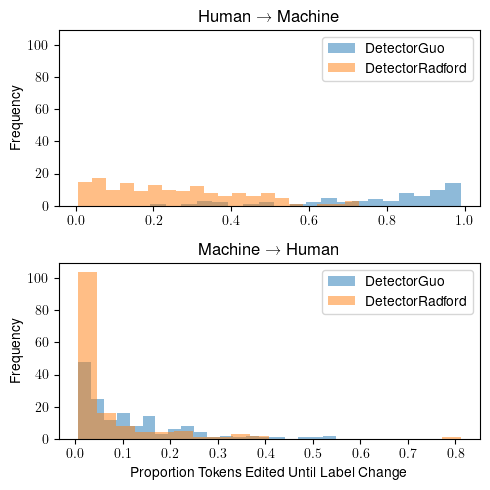

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(5,5))
df[df["f(Original)"] == 1].groupby(["Detector"])["Tokens Edited Proportion"].plot.hist(alpha=0.5, bins=20, ax=ax1 )
ax1.legend(loc="upper right")
ax1.set_title("Human → Machine")

df[df["f(Original)"] == 0].groupby(["Detector"])["Tokens Edited Proportion"].plot.hist(alpha=0.5, bins=20, ax=ax2 )
ax2.legend(loc="upper right")
ax2.set_title("Machine → Human")
ax2.set_xlabel("Proportion Tokens Edited Until Label Change ")
f.tight_layout()
plt.savefig('./figures/contrastivity-label-flip.pgf')
plt.show()

In [24]:
df[df["Tokens Edited Proportion"] <= 0.50].groupby("Detector")["Tokens Edited"].describe()

,count,mean,std,min,25%,50%,75%,max
Detector,,,,,,,,
DetectorGuo,162.0,16.753086,16.863376,1.0,3.0,10.5,24.0,73.0
DetectorRadford,290.0,15.651724,15.906716,1.0,2.0,9.0,25.0,72.0


In [25]:
df[df["Tokens Edited Proportion"] <= 0.50].groupby("Detector")["Tokens Edited Proportion"].describe()

,count,mean,std,min,25%,50%,75%,max
Detector,,,,,,,,
DetectorGuo,162.0,0.116627,0.113449,0.005747,0.023695,0.078138,0.164426,0.480519
DetectorRadford,290.0,0.136003,0.139582,0.005917,0.018868,0.072805,0.236536,0.500000


In [26]:
df = df[df["Tokens Edited Proportion"] <= 0.5]

In [27]:
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited),Tokens New Part,Tokens Original Part,Tokens Prompt,Tokens Document,Tokens Edited,Tokens Edited Proportion
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0,43,37,43,81,38,0.469136
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0,46,41,97,138,41,0.297101
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0,5,2,151,153,2,0.013072
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0,12,3,115,118,3,0.025424
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0,76,19,54,73,19,0.260274
...,...,...,...,...,...,...,...,...,...,...,...,...
602,DetectorGuo,It is possible that you may have bruised your ...,It is possible that you may have bruised your ...,It is possible that you may have bruised your ...,0,1.0,12,9,145,154,9,0.058442
604,DetectorGuo,Option contracts are generally not subject to ...,Option contracts are generally not subject to ...,Option contracts are generally not subject to ...,0,1.0,5,2,103,105,2,0.019048
606,DetectorGuo,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0,32,24,136,160,24,0.150000
608,DetectorGuo,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0,16,14,166,180,14,0.077778


In [28]:
df.groupby(["Detector", "f(Edited)"])["Tokens Edited"].describe()

count       mean        std   min    25%   50%  \
Detector        f(Edited)                                                   
DetectorGuo     0.0          9.0  42.222222  14.131328  22.0  29.00  43.0   
                1.0        153.0  15.254902  15.812441   1.0   3.00  10.0   
DetectorRadford 0.0        142.0  22.774648  15.411332   1.0  10.25  21.5   
                1.0        148.0   8.817568  13.175445   1.0   2.00   3.0   

                            75%   max  
Detector        f(Edited)              
DetectorGuo     0.0        53.0  64.0  
                1.0        21.0  73.0  
DetectorRadford 0.0        33.0  72.0  
                1.0         9.0  65.0

In [29]:
from IPython.core.display import HTML

In [30]:
# basic idea: assert that exp(original)[original - prompt] <substantially different than> exp(label_flip_example)[label_flip_example - prompt]
# i.e. the new/changed section is assigned the opposite label (TODO hard coded: "machine") more often

In [31]:
import krippendorff

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
import difflib


In [34]:
results = []
for detector_class in detector_classes:
    detector = detector_class()
    for explainer_class in explainer_classes:
            explainer = explainer_class(detector)
            for idx, (_, original, prompt, edited, f_original, f_edited, _,_,_,_,_,tokens_edited_proportion) in tqdm(list(df[df["Detector"] == detector.__class__.__name__].iterrows()), desc="Gathering results"):
                target_label = f_edited
                # if not (explainer.is_cached(original)) or not(explainer.is_cached(edited)):
                #      continue
                # The generation strategy above uses spacy's tokenizer (where punctuation chars are end up in seperate tokens). 
                # The explanation methods have their own tokenizers and FI scores are reported irt to those tokens
                # For LIME, multiple punctuation chars can end up in the same token e.g.: "!)" is one token, "!" too, "#+#++..,++##" as well. 
                # This is problematic when comparing explanations:
                # i.e. this can fail: assert explainer.tokenize(original)[0:lenght_promt] == explainer.tokenize(edited)[0:lenght_promt]
                
                # For this experiment, it is only important to separate the "prompt", which is the common part between the two documents, from the generated/cut parts
                # Determining the bounds of the prompt has to be done AFTER tokenization:
                # Strategy: change bounds until assert explainer.tokenize(original)[0:lenght_promt] == explainer.tokenize(edited)[0:lenght_promt] passes
                lenght_promt = len(explainer.tokenize(prompt)) # this would suffice for SHAP, but not for lime (because it sometimes collapses punctuation chars into one token) 
                while explainer.tokenize(original)[0:lenght_promt] != explainer.tokenize(edited)[0:lenght_promt] or len(explainer.tokenize(original)[lenght_promt:]) == 0 or len(explainer.tokenize(edited)[lenght_promt:]) == 0:    
                    lenght_promt -= 1 
                lenght_promt = max(lenght_promt, 1) # if the first word is followed by a punctuation char, e.g., "Example! Is a sentence." and the prompt is just "Example", the loop above would set lenght_promt=0. This happens as LIME tokenizes this to ['Example!', 'Is', 'a', 'sentence.']
                assert explainer.tokenize(original)[1:lenght_promt] == explainer.tokenize(edited)[1:lenght_promt]
                       
                # get cut/edited parts
                exp_original_cut_part = explainer.get_fi_scores(original, fill=True)[target_label][lenght_promt:] # TODO hard coded: "machine"
                exp_edited_new_part = explainer.get_fi_scores(edited, fill=True)[target_label][lenght_promt:] # setting fill=True returns all features (not just the top_k) 
                fi_scores_exp_original_cut_part = np.array([fi_score for _, fi_score in exp_original_cut_part])
                fi_scores_exp_edited_new_part =   np.array([fi_score for _, fi_score in exp_edited_new_part])
                

                # get common part
                exp_original_common_part = explainer.get_fi_scores(original, fill=True)[target_label][0:lenght_promt]
                exp_edited_common_part = explainer.get_fi_scores(edited, fill=True)[target_label][0:lenght_promt]
                fi_scores_exp_original_common_part = np.array([fi_score for _, fi_score in exp_original_common_part])
                fi_scores_exp_edited_common_part=    np.array([fi_score for _, fi_score in exp_edited_common_part])
                
                # build result row
                if len(fi_scores_exp_original_cut_part) == 0 or(fi_scores_exp_edited_new_part.shape[0] == 0 or fi_scores_exp_edited_common_part.shape[0] == 0 ):
                  #  print(cannonical_form.shape)
                    print(lenght_promt)
                    print(original)
                    print(prompt)
                    print(edited)
                    print(fi_scores_exp_edited_new_part)
                    print(fi_scores_exp_edited_common_part)
                    print(fi_scores_exp_original_cut_part)
               

                score_2_new_and_cut_parts_opposite = np.mean(fi_scores_exp_edited_new_part) > np.mean(fi_scores_exp_original_cut_part)
                score_4_max_fi_in_new_part = fi_scores_exp_edited_new_part.max() > fi_scores_exp_edited_common_part.max()
                score_3_new_average_higher_than_common = np.mean(fi_scores_exp_edited_new_part) > np.mean(fi_scores_exp_edited_common_part)

                cannonical_form = np.vstack([fi_scores_exp_original_common_part, fi_scores_exp_edited_common_part])
                
                assert len(fi_scores_exp_original_cut_part) > 0
                assert len(fi_scores_exp_edited_new_part) > 0
                assert len(fi_scores_exp_original_common_part) > 0
                assert len(fi_scores_exp_edited_common_part) > 0

                score_1_k_alpha = None
                if np.all(cannonical_form==0): # the krippendorff library requires items to not all be the same
                    score_1_k_alpha = 1
                else:
                    score_1_k_alpha = krippendorff.alpha(cannonical_form, level_of_measurement="interval")

                score_1_cos_sim = cosine_similarity(fi_scores_exp_original_common_part.reshape(1, -1),fi_scores_exp_edited_common_part.reshape(1, -1))[0,0]
                row =     (
                     explainer.__class__.__name__, 
                     detector.__class__.__name__, 
                     "m → h" if target_label else "h → m",
                     np.mean(fi_scores_exp_original_cut_part), 
                     np.mean(fi_scores_exp_edited_new_part), 
                     np.mean(fi_scores_exp_original_common_part), 
                     np.mean(fi_scores_exp_edited_common_part),  
                     score_1_cos_sim,               
                     score_1_k_alpha,                             
                     score_4_max_fi_in_new_part, 
                     score_2_new_and_cut_parts_opposite,
                     score_3_new_average_higher_than_common,
                     tokens_edited_proportion
                     )
                results.append(row)



Gathering results: 100%|██████████| 290/290 [10:30<00:00,  2.18s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Gathering results: 100%|██████████| 162/162 [19:26<00:00,  7.20s/it]


In [35]:
columns = ["Explainer",
          "Detector",
          "f(d) → f(m)",
          "Mean FI Original Cut Part",
          "Mean FI Edited New Part",
          "Mean FI Original Common Part",
          "Mean FI Edited Common Part",
          "[Score 1] cos sim",
          "[Score 1] Krippendorff",
          "[Score 4]",
          "[Score 2]",
          "[Score 3]",
          "Tokens Edited Proportion"]
dff = pd.DataFrame(results, columns=columns)
dff["Explainer"] = dff["Explainer"].str.replace("_Explainer", "")


In [36]:
from scipy.stats.mstats import ttest_rel
from scipy.stats.mstats import ttest_1samp

In [37]:
export_cols = [
          "[Score 1] cos sim",
          "[Score 1] Krippendorff",          
          "[Score 2]",
          "[Score 3]",
          "[Score 4]",
]

In [38]:
# some formatting functions
def get_p_asterisks(group):
    val =  group.mean()
   # print(group.name)
    _, p = ttest_1samp(group, popmean=0.5 if group.name != "[Score 1] Krippendorff" else 0) # TODO
    if p <= 0.001:
        return "{:.2f}\\textsuperscript{{***}}".format(val)
    if p <= 0.01:
        return "{:.2f}\\textsuperscript{{**}}".format(val)
    if p <= 0.05:
        return "{:.2f}\\textsuperscript{{*}}".format(val)
    if p > 0.05:
        return "{:.2f}\\textsuperscript{{ns}}".format(val)

def highlight_max(col):
    vals = col.str.extract(r"(-*\d*\.\d*)").astype(float).values.flatten()
    max_val = vals.max()
    return ["font-weight: bold;" if c == max_val else "" for c in vals ]
def df_to_latex(styled_df, caption="TODO", label="TODO"):
    return styled_df.to_latex(environment="longtable", convert_css=True, clines="all;data", hrules=True, caption=caption, label=label)

In [39]:
dff

,Explainer,Detector,f(d) → f(m),Mean FI Original Cut Part,Mean FI Edited New Part,Mean FI Original Common Part,Mean FI Edited Common Part,[Score 1] cos sim,[Score 1] Krippendorff,[Score 4],[Score 2],[Score 3],Tokens Edited Proportion
0,SHAP,DetectorRadford,h → m,-0.010459,0.006581,-0.012620,-0.013571,0.818764,0.718013,True,True,True,0.469136
1,SHAP,DetectorRadford,h → m,-0.008298,0.006963,-0.006402,-0.009255,0.860101,0.749235,True,True,True,0.297101
2,SHAP,DetectorRadford,m → h,0.004678,0.049227,0.000230,0.004298,0.554081,0.531658,True,True,True,0.013072
3,SHAP,DetectorRadford,m → h,0.048430,0.037058,-0.001217,0.001502,0.567644,0.561619,True,False,True,0.025424
4,SHAP,DetectorRadford,h → m,-0.011686,0.011136,-0.011209,-0.008203,0.800283,0.729157,True,True,True,0.260274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,LIME,DetectorGuo,m → h,0.000000,0.000088,-0.003334,-0.000009,0.000000,-0.023380,True,True,True,0.058442
900,LIME,DetectorGuo,m → h,0.000000,0.000000,-0.003967,-0.000206,0.115871,-0.028658,False,False,True,0.019048
901,LIME,DetectorGuo,m → h,0.000000,-0.000857,-0.003759,-0.000398,0.169146,0.008845,False,False,False,0.150000
902,LIME,DetectorGuo,m → h,0.000000,-0.000012,-0.001762,-0.000007,0.778471,-0.017374,False,False,False,0.077778


In [40]:
# style_bold = dff.set_index(["Explainer", "Detector","f(d) → f(m)"])[export_cols].groupby(["Detector","Explainer",  "f(d) → f(m)"]).mean().style.highlight_max(props="font-weight: bold;")

In [41]:
def style_dff(dff, groupby):
    p_results = dff.set_index(["Explainer", "Detector","f(d) → f(m)"])[export_cols].groupby(groupby).agg(
    {
          "[Score 1] cos sim": ["count", get_p_asterisks],
          "[Score 1] Krippendorff": get_p_asterisks,          
          "[Score 2]": get_p_asterisks,
          "[Score 3]": get_p_asterisks,
          "[Score 4]": get_p_asterisks,
        }
    )

    p_results[('n')] = p_results[('[Score 1] cos sim', 'count')]
    p_results = p_results.drop([('[Score 1] cos sim', 'count')], axis=1)

    p_results = p_results[[list(p_results.columns)[-1]] + list(p_results.columns)[:-1]]
    p_results.columns = [a for a, _ in p_results.columns]

    p_results = p_results.style.apply(highlight_max, subset=p_results.columns[1:])
    return p_results


In [42]:
p_results_detector_level = style_dff(dff, groupby=["Detector","Explainer",  "f(d) → f(m)"])
display(p_results_detector_level)
p_results_aggregate_level = style_dff(dff, groupby=["Explainer"])
display(p_results_aggregate_level)

,n,[Score 1] cos sim,[Score 1] Krippendorff,[Score 2],[Score 3],[Score 4]
Explainer,,,,,,
LIME,452,0.16\textsuperscript{***},0.09\textsuperscript{***},0.62\textsuperscript{***},0.69\textsuperscript{***},0.28\textsuperscript{***}
SHAP,452,0.63\textsuperscript{***},0.55\textsuperscript{***},0.93\textsuperscript{***},0.87\textsuperscript{***},0.47\textsuperscript{ns}


In [43]:
print(df_to_latex(p_results_detector_level, label="contrastivity-explainer-detector-direction", caption="Scores per detector, explainer and direction of change. For scores 2-4, higher is better") )
print(df_to_latex(p_results_aggregate_level, label="contrastivity-aggregate", caption="Aggregate Scores per Detector. For scores 2-4, higher is better") )

\begin{longtable}{lllrlllll}
\caption{Scores per detector, explainer and direction of change. For scores 2-4, higher is better} \label{contrastivity-explainer-detector-direction} \\
\toprule
 &  &  & n & [Score 1] cos sim & [Score 1] Krippendorff & [Score 2] & [Score 3] & [Score 4] \\
Detector & Explainer & f(d) → f(m) &  &  &  &  &  &  \\
\midrule
\endfirsthead
\caption[]{Scores per detector, explainer and direction of change. For scores 2-4, higher is better} \\
\toprule
 &  &  & n & [Score 1] cos sim & [Score 1] Krippendorff & [Score 2] & [Score 3] & [Score 4] \\
Detector & Explainer & f(d) → f(m) &  &  &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{9}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[c]{4}{*}{DetectorGuo} & \multirow[c]{2}{*}{LIME} & h → m & 9 & 0.16\textsuperscript{**} & -0.03\textsuperscript{*} & 0.78\textsuperscript{ns} & 0.44\textsuperscript{ns} & 0.56\textsuperscript{ns} \\
\cline{3-9}
 &  & m → h & 153 & 0.11\textsuper

In [44]:
results_explainer_level = dff.set_index(["Explainer", "Detector","f(d) → f(m)"]).groupby(["Explainer"]).mean()
results_explainer_level

,Mean FI Original Cut Part,Mean FI Edited New Part,Mean FI Original Common Part,Mean FI Edited Common Part,[Score 1] cos sim,[Score 1] Krippendorff,[Score 4],[Score 2],[Score 3],Tokens Edited Proportion
Explainer,,,,,,,,,,
LIME,-0.002755,0.002219,-0.003051,-0.000972,0.15929,0.092545,0.278761,0.623894,0.694690,0.129058
SHAP,-0.011527,0.015528,-0.004350,-0.003632,0.63023,0.545648,0.471239,0.926991,0.871681,0.129058


In [45]:
import seaborn as sns
from scipy import stats


In [46]:
# print(plt.rcParams['axes.prop_cycle'].by_key()['color'])


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


NameError: name 'width' is not defined

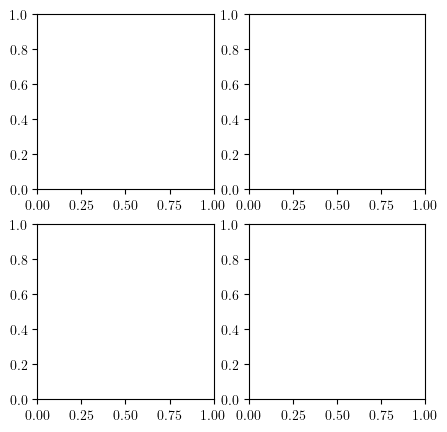

In [47]:
# f, (a, b) = plt.subplots(2, 2, sharey=False, figsize=(5,5))
# for ax2, (name, group) in zip(b, dff.groupby("Explainer")):
    
#     x = group["Tokens Edited Proportion"].astype(float).to_numpy()
#     y = group["[Score 4]"].astype(float).to_numpy()

   
#     count, bin_edges_count,_ = stats.binned_statistic(x, y, 'count', bins=10)
#     ax2.bar(bin_edges_count[:-1] + ((bin_edges_count[1:] -bin_edges_count[:-1]) /2), count,width=width, lw=2, color=p[-1].get_color(),
#            label="Count", alpha=0.5)
# for ax1, (name, group) in zip(a, dff.groupby("Explainer")):   
    
#     x = group["Tokens Edited Proportion"].astype(float).to_numpy()
#     y = group["[Score 4]"].astype(float).to_numpy()

#     mean_score, bin_edges,_ = stats.binned_statistic(x, y, 'mean', bins=10)
    
#     print(count)
#     assert all(bin_edges == bin_edges_count)
    

#     z = np.polyfit(x, y, 1)
#     p = np.poly1d(z)
#     p =ax1.plot(x,p(x),"--")


#     width = bin_edges[1:] -bin_edges[:-1]
#     ax1.bar(bin_edges[:-1] + ((bin_edges[1:] -bin_edges[:-1]) /2), mean_score,width=width, lw=2, color=p[-1].get_color(),
#            label=name, alpha=0.5)
#     ax1.set_title(name)
# a[0].set_ylabel("Score 4")
# b[0].set_ylabel("Number of documents")

# f.tight_layout()
# plt.savefig('./figures/contrastivity-score-4-hists.pgf')
# plt.show()


In [ ]:
# df["Tokens Edited Proportion"]

0      0.469136
1      0.297101
2      0.013072
3      0.025424
4      0.260274
         ...   
602    0.058442
604    0.019048
606    0.150000
608    0.077778
609    0.251534
Name: Tokens Edited Proportion, Length: 452, dtype: float64

In [ ]:
# # ttest_rel
# for col_original, col_edited in [("Mean FI Original Cut Part","Mean FI Edited New Part"), ("Mean FI Original Common Part", "Mean FI Edited Common Part")]:
#     print(col_original, col_edited)
#     print(dff.set_index(["Explainer", "Detector"]).groupby(["Explainer"]).apply(lambda group: ttest_rel(group[col_original], group[col_edited])))

Mean FI Original Cut Part Mean FI Edited New Part
Explainer
LIME    (-9.733135915253126, 5.253706961709181e-20)
SHAP    (-16.55405381826774, 1.637526497494269e-46)
dtype: object
Mean FI Original Common Part Mean FI Edited Common Part
Explainer
LIME    (-12.026002064918758, 3.447618735953577e-28)
SHAP     (-8.606593135212606, 2.147838940793738e-16)
dtype: object


In [ ]:
# for col in [ "[Score 1] cos_sim",
#           "[Score 1] Krippendorff",
#           "[Score 4]",
#           "[Score 2]",
#           "[Score 3]"]:
#     print(col)
#     print(dff.set_index(["Explainer", "Detector"]).groupby(["Explainer","f(d) → f(m)"]).apply(lambda group: ttest_1samp(group[col], popmean=0.5)))

[Score 1] cos_sim


KeyError: '[Score 1] cos_sim'

In [ ]:
# for col in [ "[Score 1] cos_sim Common Part",
#           "[Score 1] Krippendorff's Alpha Common Part",
#           "[Score 4] Maximum FI in new part",
#           "[Score 2] New and Cut Parts Opposite",
#           "[Score 3] New Higher Average than Common Part"]:
#     print(col)

#     print(ttest_rel(dff[dff["Explainer"] == "LIME_Explainer"][col].astype(float), dff[dff["Explainer"] == "SHAP_Explainer"][col].astype(float)))

[Score 1] cos_sim Common Part


ValueError: unequal length arrays